# **Load the packages**
The core package used in this tutorial is scikit-learn (sklearn).

Regular expressions re, gensim and spacy are used to process texts. pyLDAvis and matplotlib for visualization and numpy and pandas for manipulating and viewing data in tabular format.

Let us import them

In [1]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [2]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 3.2MB/s 
     |████████████████████████████████| 552kB 43.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=12f7ba9d6e818d607c3688f304fc590cdbe97f0572ace9cb2ee77eec18001674
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=50a9c207214b69c221c7ac7a4e1e20562deefb602492ce79f79e917ec328cbf2
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from sklearn.feature_extraction import text
#np.random.seed(100)
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from scipy.stats import entropy

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# **Read Linkedin Data**

In [0]:
df=pd.read_excel('/content/DatsetUsedForTraining_version2.xlsx')

In [0]:
df.reset_index(inplace=True)

In [6]:
df.shape

(5853, 24)

In [7]:
df.tail(2)

,index,Unnamed: 0,Unnamed: 0.1,Name,Summary,Skills,Experience_1,Current_Organization,Designation_1,ExpDurationInMonths_1,Experience_2,Designation_2,ExpDurationInMonths_2,Education_1,EduDurationInMonths_1,Education_2,EduDurationInMonths_2,Total_Exp,Total_Edu,URL,Domain,Summary_Final,Summarized_Text,New_Skills
5851,5851,5855,954,Debanik Biswas, An out-of-box thinker which has a proven tra...,"['Sales Operations', 'Business Development', '...",Zonal Manager - Sales and Marketing\nCompany N...,INTERNATIONAL CORPORATE (SKYLED TV | SKYMUSIC ...,Zonal Manager - Sales and Marketing,14,Regional Business Head\nCompany Name\nMCC Glob...,Regional Business Head,17,CALCUTTA UNIVERSITY\nDegree Name\nBachelor's D...,2,OCS Portsea\nDegree Name\nGraduate Diploma Man...,1,31,3,https://www.linkedin.com/in/debanik-biswas-130...,NaN,An out of box thinker which has a proven track...,An out of box thinker which has a proven track...,"['Sales Operations', 'Business Development', '..."
5852,5852,5856,1002,Srijit Das,► An extremely conscientious and dedicated Sen...,"['Employee Engagement', 'Management', 'Change ...",zonal human resource manager\nCompany Name\nHi...,Hinduja Leyland Finance Limited,zonal human resource manager,24,Senior Manager - State Human Capital - General...,Senior Manager - State Human Capital - Generalist,77,"I.H.M., Taratala\nDegree Name\nDegree\nField O...",2,Assembly of God Church\nDegree Name\nBachelor'...,4,101,6,https://www.linkedin.com/in/srijit-das-3023655...,NaN,An extremely conscientious and dedicated senio...,An extremely conscientious and dedicated senio...,"['Employee Engagement', 'Management', 'Change ..."


In [0]:
df.index = pd.RangeIndex(len(df.index))

In [0]:
df.drop(['Unnamed: 0'],inplace=True,axis=1)

In [10]:
df['ExpDurationInMonths_1']=df['ExpDurationInMonths_1'].astype("Float32").astype("Int32")
df['ExpDurationInMonths_2']=df['ExpDurationInMonths_2'].astype("Float32").astype("Int32")
df['EduDurationInMonths_1']=df['EduDurationInMonths_1'].astype("Float32").astype("Int32")
df['EduDurationInMonths_2']=df['EduDurationInMonths_2'].astype("Float32").astype("Int32")
df['Total_Exp']=df['Total_Exp'].astype("Float32").astype("Int32")
df['Total_Edu']=df['Total_Edu'].astype("Float32").astype("Int32")

/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/common.py:1874: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  npdtype = np.dtype(dtype)
/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/common.py:1874: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  npdtype = np.dtype(dtype)
/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/common.py:1874: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  npdtype = np.dtype(dtype)
/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/common.py:1874: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  npdtype = np.dtype(dtype)
/usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/common.py:1874: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  n

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [12]:
df.columns

Index(['index', 'Unnamed: 0.1', 'Name', 'Summary', 'Skills', 'Experience_1',
       'Current_Organization', 'Designation_1', 'ExpDurationInMonths_1',
       'Experience_2', 'Designation_2', 'ExpDurationInMonths_2', 'Education_1',
       'EduDurationInMonths_1', 'Education_2', 'EduDurationInMonths_2',
       'Total_Exp', 'Total_Edu', 'URL', 'Domain', 'Summary_Final',
       'Summarized_Text', 'New_Skills'],
      dtype='object')

# **Club Text Column in to a single column**

In [0]:
df["ColumnA"]= df["Summary_Final"].astype(str) + ',' + df["New_Skills"].astype(str) + ',' +df["Experience_1"].astype(str) + ',' +df["Designation_1"]+ ',' +df["Experience_2"].astype(str) + ',' +df["Designation_2"].astype(str) + ',' +df["Education_1"].astype(str) + ',' +df["Education_2"].astype(str)

In [0]:
df=df[~df['ColumnA'].isna()]

In [15]:
df.shape

(5853, 24)

In [20]:
df.columns

Index(['index', 'Unnamed: 0.1', 'Name', 'Summary', 'Skills', 'Experience_1',
       'Current_Organization', 'Designation_1', 'ExpDurationInMonths_1',
       'Experience_2', 'Designation_2', 'ExpDurationInMonths_2', 'Education_1',
       'EduDurationInMonths_1', 'Education_2', 'EduDurationInMonths_2',
       'Total_Exp', 'Total_Edu', 'URL', 'Domain', 'Summary_Final',
       'Summarized_Text', 'New_Skills', 'ColumnA'],
      dtype='object')

# **Convert Text Column in to a list**

In [0]:
# Convert to list
data = df.ColumnA.values.tolist()

In [0]:
data = [x for x in data if str(x) != 'nan']

# **Function to Clean Text**

In [0]:
def clean_text(text):
    for ch in ['\n','                               ','\\n','.',"\'",'\\s','[]','[]','[',']','-','"','=>',':','\\uf','=','(',')','\\xa0','•','&','.',',',"'"]:
        if ch in text:
            text = text.replace(ch," ")
            text=re.sub(r"\d{4}-\d{4}", '', text)
    return text

In [23]:
data = [clean_text(sent) for sent in data]
print('CLEANED TEXT: ',data[:1])

CLEANED TEXT:  ['Experienced retail   corporate banking professional having held a number of senior positions with leading uk and overseas banks Leading significant change in operational control frameworks in a regulated environment  direct operational management of multi site functions as well as leading internal cultural change in regulated areas   Click on more to see more   Risk Management    Stakeholder Management    Banking    Service Director  Head of Operations   Remediation Company Name Santander UK Dates Employed Jun 2012 – Present Employment Duration 7 yrs 10 mos Location London   Milton Keynes  United Kingdom Direct Responsibility for Multi Site Operations for Complex Complaint Handling in the UK   Offshore Including  Investments  Share dealing  PPI  Life  Pensions  Centralised FOS Operations  Large Scale Remediation Operations and Financial Crime  Technology and digital serving design   implementation across multi platform environments to drive high customer advocacy  simp

# **Function to Tokenize**
We want to tokenize each sentence into a list of words, removing punctuations and unnecessary characters.
Gensim’s simple_preprocess() is great for this. We can set deacc=True to remove the punctuations if any.

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [25]:
data_words = list(sent_to_words(data))
print('TOKENIZED WORDS: ',data_words[:1])

TOKENIZED WORDS:  [['experienced', 'retail', 'corporate', 'banking', 'professional', 'having', 'held', 'number', 'of', 'senior', 'positions', 'with', 'leading', 'uk', 'and', 'overseas', 'banks', 'leading', 'significant', 'change', 'in', 'operational', 'control', 'frameworks', 'in', 'regulated', 'environment', 'direct', 'operational', 'management', 'of', 'multi', 'site', 'functions', 'as', 'well', 'as', 'leading', 'internal', 'cultural', 'change', 'in', 'regulated', 'areas', 'click', 'on', 'more', 'to', 'see', 'more', 'risk', 'management', 'stakeholder', 'management', 'banking', 'service', 'director', 'head', 'of', 'operations', 'remediation', 'company', 'name', 'santander', 'uk', 'dates', 'employed', 'jun', 'present', 'employment', 'duration', 'yrs', 'mos', 'location', 'london', 'milton', 'keynes', 'united', 'kingdom', 'direct', 'responsibility', 'for', 'multi', 'site', 'operations', 'for', 'complex', 'complaint', 'handling', 'in', 'the', 'uk', 'offshore', 'including', 'investments', '

# **Function to Lemmatize**
Lemmatization is a process where we convert words to its root word.
For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.
The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.
You can expect better topics to be generated in the end

In [0]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [27]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['experienced retail corporate banking professional have hold number senior position lead overseas bank lead significant change operational control framework regulated environment direct operational management multi site function as well lead internal cultural change regulated area click more see more risk management stakeholder service director head operation remediation company name santander date employ present employment duration responsibility multi site operation complex complaint handle offshore include investment share deal life pension centralise fos operation large scale remediation operation financial crime technology digital serve design implementation multi platform environment drive high customer advocacy simplify process cost unit reduction handle claim proactive customer complaint high risk retail corporate fin crime operation conduct relate remediation incident management align group principal platform digitalisation objective operation fca register person responsible 

# **Create the Document-Word matrix**

The LDA topic model algorithm requires a document word matrix as the main input.
We can create one using CountVectorizer. 
In the below code,the CountVectorizer has been configured to consider words that has occurred at least 10 times (min_df), 
remove built-in english stopwords, convert all words to lowercase.
So, to create the doc-word matrix, you need to first initialise the CountVectorizer class with the required configuration and then apply fit_transform to actually create the matrix.
Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.
If we want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.

In [0]:
my_stop_words=text.ENGLISH_STOP_WORDS.union(['management','date','attend','business','expect','attend','company','year','medium','ensure','work','year','include','study','duration','present','new','key','title','level','high','click','strong','ha', 'le', 'u', 'wa','end','employee','track','record'])

In [0]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=my_stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

# **Build LDA model with sklearn**

Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.
I have set the n_topics as 7 based on prior knowledge about the dataset. Later we will find the optimal number using grid search

In [32]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=7,                # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=7, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)


# **Diagnose model performance with perplexity and log-likelihood**

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good


In [33]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -5103114.646893419
Perplexity:  646.7767203027004
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 7,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': None,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


Perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words. This can be captured using topic coherence measure

# **How to GridSearch the best LDA model?**

The most important tuning parameter for LDA models is n_components (number of topics).We can search learning_decay (which controls the learning rate) as well.
Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter.
Only n_components and learning_decay is used in our case

In [34]:
# Define Search Param
search_params = {'n_components': [3,4], 'learning_decay': [.5, .7, .9],'learning_offset':[50.,10.0]}

#random_state=100,
# Init the Model
lda = LatentDirichletAllocation(learning_method='online',n_jobs = -1,random_state=100)
#learning_offset=50.,learning_offset=10.0,max_iter=10,max_iter=5
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='online',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=-1,
                                                 perp_tol=0.1, random_state=100,
                                                 topic_word_prior=None,
                                                 total_samples=1000000.0,
                              

# **How to see the best topic model and its parameters?**

In [35]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

#Best Model's Params:  {'learning_decay': 0.7, 'n_components': 4}
#Best Log Likelihood Score:  -663478.8921692774
#Model Perplexity:  527.1068759140958

Best Model's Params:  {'learning_decay': 0.7, 'learning_offset': 10.0, 'n_components': 4}
Best Log Likelihood Score:  -1055566.6158371945
Model Perplexity:  680.476937575118


# **Compare the LDA performance score**

In [0]:
df_cv_results = pd.DataFrame(model.cv_results_)
df_cv_results.to_csv("/content/LDAGridSearchResults.csv", header=True, index=False, encoding='utf-8')

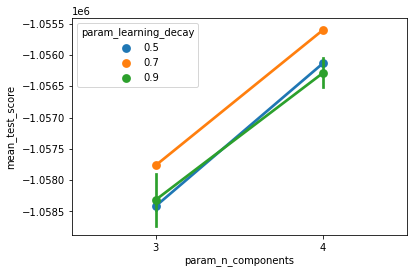

In [37]:
sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

# **How to see the dominant topic in each document?**

To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In the table below,all major topics in a document have been greened out and assigned the most dominant topic in its own column.

In [38]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topics = df_document_topic.head(15)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.35,0.40,0.17,0.08,1
Doc1,0.19,0.67,0.00,0.13,1
Doc2,0.01,0.01,0.98,0.01,2
Doc3,0.07,0.00,0.93,0.00,2
Doc4,0.01,0.01,0.98,0.01,2
Doc5,0.01,0.01,0.01,0.98,3
Doc6,0.95,0.00,0.00,0.05,0
Doc7,0.00,0.99,0.00,0.00,1
Doc8,0.04,0.95,0.00,0.00,1
Doc9,0.00,0.04,0.87,0.08,2


# **Review topics distribution across documents**

In [39]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,1950
1,2,1773
2,1,1168
3,0,962


# **How to visualize the LDA model with pyLDAvis?**

The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. So, we are good.

In [40]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398  1       1        32.173616
2      1.782994   -295.079681  2       1        26.439443
0      220.811432 -343.832123  3       1        23.628144
1      50.533993  -76.050934   4       1        17.758798, topic_info=                Term          Freq         Total Category  logprob  loglift
1905  marketing       13908.000000  13908.000000  Default  30.0000  30.0000
1274  finance         8304.000000   8304.000000   Default  29.0000  29.0000
1275  financial       5341.000000   5341.000000   Default  28.0000  28.0000
3072  supply          4036.000000   4036.000000   Default  27.0000  27.0000
2668  resource        4418.000000   4418.000000   Default  26.0000  26.0000
3104  talent          3929.000000   3929.000000   Default  25.0000  25.0000
492   chain           3560.000000   3560.000000   Default  24.0000  24.0000
1530  human           3335.000000   3335.000000   Default  23.0000  23.0000
386   brand           3711.000000   3711.000000   Default  22.0000  22.0000
2740  sale            6038.000000   6038.000000   Default  21.0000  21.0000
26    account         3044.000000   3044.000000   Default  20.0000  20.0000
31    accounting      2122.000000   2122.000000   Default  19.0000  19.0000
2127  operation       10428.000000  10428.000000  Default  18.0000  18.0000
1903  market          4230.000000   4230.000000   Default  17.0000  17.0000
1843  logistic        2193.000000   2193.000000   Default  16.0000  16.0000
2566  recruitment     2215.000000   2215.000000   Default  15.0000  15.0000
819   customer        4164.000000   4164.000000   Default  14.0000  14.0000
926   digital         1857.000000   1857.000000   Default  13.0000  13.0000
2641  report          2899.000000   2899.000000   Default  12.0000  12.0000
1689  inventory       1325.000000   1325.000000   Default  11.0000  11.0000
3375  warehouse       1321.000000   1321.000000   Default  10.0000  10.0000
732   control         1915.000000   1915.000000   Default  9.0000   9.0000 
30    accountant      1063.000000   1063.000000   Default  8.0000   8.0000 
3121  tax             1035.000000   1035.000000   Default  7.0000   7.0000 
3014  strategy        6147.000000   6147.000000   Default  6.0000   6.0000 
2407  process         4942.000000   4942.000000   Default  5.0000   5.0000 
43    acquisition     2299.000000   2299.000000   Default  4.0000   4.0000 
259   audit           1179.000000   1179.000000   Default  3.0000   3.0000 
2413  product         3223.000000   3223.000000   Default  2.0000   2.0000 
762   cost            2290.000000   2290.000000   Default  1.0000   1.0000 
1905  marketing       13907.898142  13908.902002  Topic1  -2.9036   1.1340 
926   digital         1856.471219   1857.259252   Topic1  -4.9174   1.1336 
432   campaign        1316.649702   1317.412676   Topic1  -5.2610   1.1334 
386   brand           3709.327571   3711.948176   Topic1  -4.2252   1.1333 
713   content         839.381993    840.208781    Topic1  -5.7112   1.1330 
49    activation      202.937708    203.695214    Topic1  -7.1310   1.1303 
2815  seo             199.970363    200.717282    Topic1  -7.1457   1.1303 
1904  marketer        199.999269    200.746806    Topic1  -7.1455   1.1303 
2444  promotional     173.799140    174.575940    Topic1  -7.2860   1.1296 
3348  video           170.161499    170.954353    Topic1  -7.3071   1.1294 
257   audience        166.208125    166.992946    Topic1  -7.3306   1.1293 
2346  pr              145.913362    146.660936    Topic1  -7.4608   1.1289 
1031  ecommerce       165.910741    166.760912    Topic1  -7.3324   1.1289 
2957  sponsorship     153.959507    154.754711    Topic1  -7.4072   1.1289 
2452  proposition     137.713106    138.522249    Topic1  -7.5187   1.1282 
3265  tv              135.076268    135.883084    Topic1  -7.5380   1.1281 
1600  influencer      123.738377    1

# **How to see the Topic’s keywords?**

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic

In [41]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

ability       able    abreast     abroad    absence        aca  \
Topic0  335.188562  60.859222  18.426953  6.976733   4.374843   0.256703    
Topic1  103.926602  22.534466  0.260437   10.030734  0.257619   13.726617   
Topic2  267.002617  62.179471  0.259203   0.414056   33.699809  0.254881    
Topic3  173.551766  62.274382  3.386836   39.201837  0.252349   0.252562    

         academic       acca  accelerate  accelerated  acceleration  \
Topic0  7.986513   0.251016   13.478959   0.255584     0.253928       
Topic1  19.155653  32.401196  5.267101    0.262064     0.252978       
Topic2  45.817008  0.251223   14.597551   6.604499     5.914802       
Topic3  77.239326  0.250414   63.282799   10.681942    12.158607      

        accelerator  accenture     accept  acceptance     access  accessory  \
Topic0  0.250507     0.259493   5.112979   23.291920   36.801293  24.622908   
Topic1  0.253781     0.362818   15.333635  0.314858    16.274605  0.272054    
Topic2  0.272464     23.026440  14.925712  4.583434    28.569425  0.254847    
Topic3  22.577466    7.845926   10.566921  2.924127    97.725925  17.241929   

         accolade  accommodation  accompany  accomplish  accomplished  \
Topic0  0.326196   3.761803       2.183845   80.152632   14.676363      
Topic1  2.033799   0.291804       0.278221   34.641457   10.637402      
Topic2  4.874805   12.709690      6.261982   26.687706   24.020521      
Topic3  11.408641  8.325868       2.813233   38.633995   33.243716      

        accomplishment     accord  accordance  accordingly      account  \
Topic0  43.933490       28.637821  29.586910   51.350603    125.212061    
Topic1  21.174952       10.789565  37.193495   0.275396     2412.952298   
Topic2  17.892181       21.413121  20.444262   9.981560     30.748601     
Topic3  28.069731       4.854139   0.261466    11.968277    424.915220    

        accountability  accountable  accountancy   accountant   accounting  \
Topic0  71.088696       76.754025    0.261323     0.253895     0.460756      
Topic1  2.420256        22.904725    122.051033   1032.858748  2060.519519   
Topic2  53.849109       83.487240    6.227837     0.254724     0.272285      
Topic3  66.330293       77.523630    1.314314     0.252472     0.256812      

         accredit  accreditation    accrual    accuracy   accurate  \
Topic0  0.879249   0.282799       1.907532   166.785563  81.637054   
Topic1  6.570270   0.267810       40.808003  34.556646   90.164133   
Topic2  20.331187  56.086280      0.250349   0.259340    16.331382   
Topic3  12.265757  0.287406       0.250923   0.261314    0.272927    

        accurately     achieve  achievement  achiever  acknowledge    acquire  \
Topic0  22.853568   592.907155  218.879157   3.253599  7.551592     29.736025   
Topic1  6.475268    78.458744   54.662486    1.446798  3.831526     51.611279   
Topic2  4.684659    196.411692  84.687665    0.359660  0.371598     72.589008   
Topic3  0.287805    488.845321  148.904040   8.864894  6.648229     58.296014   

        acquisition       acre         act      action  actionable   activate  \
Topic0  0.391797     3.634447   58.181859   191.134400  4.661596    2.913240    
Topic1  113.041730   0.272547   70.666382   52.974778   16.837694   0.288572    
Topic2  1940.328952  0.261077   134.644458  98.759219   0.311316    6.974343    
Topic3  300.947031   10.391248  55.082421   67.795287   28.682982   19.562965   

        activation     active   actively     activity     actual     acuman  \
Topic0  0.260675    65.319313  46.637615  845.641092   40.602305  38.941457   
Topic1  0.252528    30.961435  31.033735  525.373515   89.069520  17.468119   
Topic2  0.251716    98.742737  45.257030  949.960776   0.294168   33.487870   
Topic3  210.751371  67.499248  58.947544  1619.327732  0.324521   48.166531   

            acute          ad      adapt  adaptability  adaptable   adaptive  \
Topic0  0.258211   0.314093    31.909588  4.361042      14.256672  11.321296   
Topic1  0.268887   0.

# **Get the top 15 keywords each topic**

From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that

In [42]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=100)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49,Word 50,Word 51,Word 52,Word 53,Word 54,Word 55,Word 56,Word 57,Word 58,Word 59,Word 60,Word 61,Word 62,Word 63,Word 64,Word 65,Word 66,Word 67,Word 68,Word 69,Word 70,Word 71,Word 72,Word 73,Word 74,Word 75,Word 76,Word 77,Word 78,Word 79,Word 80,Word 81,Word 82,Word 83,Word 84,Word 85,Word 86,Word 87,Word 88,Word 89,Word 90,Word 91,Word 92,Word 93,Word 94,Word 95,Word 96,Word 97,Word 98,Word 99
Topic 0,operation,supply,chain,manager,team,process,logistic,project,customer,service,employ,manage,inventory,cost,warehouse,planning,plan,graduation,experience,improvement,employment,material,time,support,quality,operational,lead,responsible,develop,activity,procurement,delivery,implement,performance,distribution,control,field,production,maintain,report,order,vendor,development,requirement,improve,handle,sale,skill,good,product,contract,implementation,achieve,engineering,provide,supplier,monitor,degree,staff,stock,day,area,coordinate,facility,training,professional,identify,set,global,analysis,result,client,various,solution,efficiency,head,grade,standard,purchase,plant,review,manufacturing,change,meet,design,source,reduce,industry,effective,target,drive,safety,budget,procedure,transportation,function,strategic,senior,site,manufacture
Topic 1,finance,financial,employ,account,accounting,employment,report,graduation,analysis,control,head,manager,experience,audit,accountant,team,corporate,tax,process,director,compliance,internal,reporting,cost,senior,service,risk,banking,bank,operation,cash,manage,budget,group,project,monthly,degree,field,review,preparation,area,planning,professional,support,credit,lead,activity,prepare,responsible,function,investment,provide,strategic,commercial,statutory,global,charter,various,industry,annual,statement,capital,time,fund,taxation,payment,forecast,plan,chief,legal,implementation,general,total,asset,revenue,budgeting,reconciliation,officer,policy,flow,loan,forecasting,grade,executive,controller,regulatory,partner,leadership,entity,analyst,member,performance,drive,balance,procedure,decision,information,transaction,term,external
Topic 2,employ,resource,talent,human,employment,graduation,team,manager,recruitment,performance,development,head,experience,acquisition,service,partner,lead,process,people,senior,leadership,operation,global,professional,relation,strategy,engagement,degree,manage,field,support,policy,training,role,program,change,recruit,strategic,area,leader,director,activity,provide,function,responsible,organization,technology,develop,hire,drive,benefit,client,executive,candidate,time,compensation,total,industry,hr,design,skill,implement,initiative,group,plan,project,job,organizational,handle,personnel,good,source,solution,focus,delivery,practice,planning,corporate,grade,culture,career,build,need,interview,deliver,staff,various,administration,compliance,member,consultant,society,transformation,payroll,requirement,implementation,organisation,regional,information,create
Topic 3,marketing,employ,sale,strategy,market,brand,employment,graduation,team,manager,head,lead,product,director,communication,development,customer,operation,experience,digital,field,activity,drive,develop,degree,global,growth,manage,campaign,service,event,social,strategic,industry,plan,senior,consumer,retail,responsible,society,time,area,professional,program,partner,leadership,total,channel,technology,build,content,launch,create,deliver,client,revenue,leader,planning,project,corporate,president,role,focus,research,solution,vice,advertising,executive,support,design,regional,online,grade,creative,help,execution,member,increase,international,target,analy

In [0]:
df_topic_keywords.to_excel('/content/TopicKeyword.xlsx')

# **Put the 4 topics that can be infered into the dataframe**

In [43]:
Topics = ["Operations","Finance","HR","Marketing"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20,Word 21,Word 22,Word 23,Word 24,Word 25,Word 26,Word 27,Word 28,Word 29,Word 30,Word 31,Word 32,Word 33,Word 34,Word 35,Word 36,Word 37,Word 38,Word 39,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49,Word 50,Word 51,Word 52,Word 53,Word 54,Word 55,Word 56,Word 57,Word 58,Word 59,Word 60,Word 61,Word 62,Word 63,Word 64,Word 65,Word 66,Word 67,Word 68,Word 69,Word 70,Word 71,Word 72,Word 73,Word 74,Word 75,Word 76,Word 77,Word 78,Word 79,Word 80,Word 81,Word 82,Word 83,Word 84,Word 85,Word 86,Word 87,Word 88,Word 89,Word 90,Word 91,Word 92,Word 93,Word 94,Word 95,Word 96,Word 97,Word 98,Word 99,Topics
Topic 0,operation,supply,chain,manager,team,process,logistic,project,customer,service,employ,manage,inventory,cost,warehouse,planning,plan,graduation,experience,improvement,employment,material,time,support,quality,operational,lead,responsible,develop,activity,procurement,delivery,implement,performance,distribution,control,field,production,maintain,report,order,vendor,development,requirement,improve,handle,sale,skill,good,product,contract,implementation,achieve,engineering,provide,supplier,monitor,degree,staff,stock,day,area,coordinate,facility,training,professional,identify,set,global,analysis,result,client,various,solution,efficiency,head,grade,standard,purchase,plant,review,manufacturing,change,meet,design,source,reduce,industry,effective,target,drive,safety,budget,procedure,transportation,function,strategic,senior,site,manufacture,Operations
Topic 1,finance,financial,employ,account,accounting,employment,report,graduation,analysis,control,head,manager,experience,audit,accountant,team,corporate,tax,process,director,compliance,internal,reporting,cost,senior,service,risk,banking,bank,operation,cash,manage,budget,group,project,monthly,degree,field,review,preparation,area,planning,professional,support,credit,lead,activity,prepare,responsible,function,investment,provide,strategic,commercial,statutory,global,charter,various,industry,annual,statement,capital,time,fund,taxation,payment,forecast,plan,chief,legal,implementation,general,total,asset,revenue,budgeting,reconciliation,officer,policy,flow,loan,forecasting,grade,executive,controller,regulatory,partner,leadership,entity,analyst,member,performance,drive,balance,procedure,decision,information,transaction,term,external,Finance
Topic 2,employ,resource,talent,human,employment,graduation,team,manager,recruitment,performance,development,head,experience,acquisition,service,partner,lead,process,people,senior,leadership,operation,global,professional,relation,strategy,engagement,degree,manage,field,support,policy,training,role,program,change,recruit,strategic,area,leader,director,activity,provide,function,responsible,organization,technology,develop,hire,drive,benefit,client,executive,candidate,time,compensation,total,industry,hr,design,skill,implement,initiative,group,plan,project,job,organizational,handle,personnel,good,source,solution,focus,delivery,practice,planning,corporate,grade,culture,career,build,need,interview,deliver,staff,various,administration,compliance,member,consultant,society,transformation,payroll,requirement,implementation,organisation,regional,information,create,HR
Topic 3,marketing,employ,sale,strategy,market,brand,employment,graduation,team,manager,head,lead,product,director,communication,development,customer,operation,experience,digital,field,activity,drive,develop,degree,global,growth,manage,campaign,service,event,social,strategic,industry,plan,senior,consumer,retail,responsible,society,time,area,professional,program,partner,leadership,total,channel,technology,build,content,launch,create,deliver,client,revenue,leader,planning,project,corporate,president,role,focus,research,solution,vice,advertising,executive,support,design,regional,online,grade,creative,help,execution,member,increa

In [0]:
df_topic_keywords.to_excel('/content/TopicKeywordDistribution.xlsx')

# **How to fetch similar documents matching the Query Text**

In [0]:
def jensen_shannon(query, matrix):
    import numpy as np
    import scipy.stats
    p = query# take transpose
    q = matrix# transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(scipy.stats.entropy(p,m) + scipy.stats.entropy(q,m)))

# **How to predict the topics for a new piece of text?**

Assuming that we have already built the topic model, we need to take the text through the same routine of transformations before predicting the topic.

For our case, the order of transformations is:

clean_text() -> sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()

You need to apply these transformations in the same order. So to simplify it, let’s combine these steps into a predict_topic() function

In [0]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
    global jensen_shannon
    # Step 1: Clean with simple_preprocess
    mytext_1 = [clean_text(text)]
    # Step 2: Tokenize
    mytext_2 = list(sent_to_words(mytext_1))
    # Step 3: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    # Step 4: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
    # Step 5: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    # Step 6: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    sims=[]
    query=topic_probability_scores.ravel()
    for doc in lda_output:
      dist = jensen_shannon(query,doc)
      sims.append(dist)
    indices=np.argsort(sims)[:5]
    most_similar_df = df[df.index.isin(indices)]
    return infer_topic,most_similar_df,indices

In [47]:
# Predict the topic for HR
mytext = "Talent Aquisition"
infer_topic, df_result, indices = predict_topic(text = mytext)
print(infer_topic)
print(df_result)
print(indices)

HR
      index  Unnamed: 0.1                     Name  \
699   699    702           Meng (Athena) Lian, PHR   
3528  3528   3541          Jogesh Gangadharan        
4197  4197   4210          Corrinne Zuchetti         
4952  4952   217           Sajit T.C.                
5684  5684   931           Andrew Scully             

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [48]:
# Predict the topic for Operations
mytext = "professionals logistics"
infer_topic, df_result, indices = predict_topic(text = mytext)
print(infer_topic)
print(df_result)
print(indices)

Operations
      index  Unnamed: 0.1               Name  \
405   405    407           NAVEEN KUMAR        
1298  1298   1302          Dr. Arunachalam R   
1583  1583   1588          William Koetz       
2925  2925   2935          Uttam Halder        
3549  3549   3562          Avijit Majumder     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [0]:
df.iloc[3807]

index                                                                 3807
Current_Organization                                   OLA SHUTTLE KOLKATA
Designation_1            OLA SHUTTLE KOLKATA OPERATIONS SPECIALIST (FEB...
Designation_2                  SENIOR LOGISTIC AND OPERATIONS PROFESSIONAL
Domain                                                                 NaN
EduDurationInMonths_1                                                    2
EduDurationInMonths_2                                                    2
Education_1              SCDL Degree Name Master of Business Administra...
Education_2              Heramba Chandra College Degree Name Higher sec...
ExpDurationInMonths_1                                                   50
ExpDurationInMonths_2                                                   50
Experience_1             OLA SHUTTLE KOLKATA OPERATIONS SPECIALIST (FEB...
Experience_2             SENIOR LOGISTIC AND OPERATIONS PROFESSIONAL Co...
Name                     

In [49]:
# Predict the topic for Marketing
mytext = "Professionals having exposure in promotional activities"
infer_topic, df_result, indices= predict_topic(text = mytext)
print(infer_topic)
print(df_result)
print(indices)

Marketing
      index  Unnamed: 0.1                       Name  \
272   272    273           Benjamin Barthelmé          
340   340    341           Marcelo Salas               
3161  3161   3172          Deirdre Campbell FAMI CPM   
3573  3573   3586          Prashasti Bali              
4275  4275   4288          Munish Sharma               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [0]:
df.drop(df.index[4902],inplace=True,axis=0)

In [50]:
mytext = "Professionals having exposure in accounting"
infer_topic, df_result, indices = predict_topic(text = mytext)
print(infer_topic)
print(df_result)
print(indices)

Finance
      index  Unnamed: 0.1              Name  \
1136  1136   1140          Sunil Gupta        
1424  1424   1428          Paul Shields       
2229  2229   2236          Jason de Bruin     
5138  5138   866           Dr.Vikraman N      
5820  5820   155           Michael Malewicz   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [53]:
mytext = "Professionals having exposure in Warehouse Management with 5 years experience"
infer_topic, df_result, indices = predict_topic(text = mytext)
print(infer_topic)
print(df_result)
print(indices)

Operations
      index  Unnamed: 0.1             Name  \
339   339    340           Alex Jacob        
1583  1583   1588          William Koetz     
3217  3217   3228          Chris Underwood   
3719  3719   3732          Stuart Doncon     
5605  5605   849           Devaraju C        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [0]:
df.iloc[346]

index                                                                  346
Current_Organization                                                 LIXIL
Designation_1            Head  Service Planning, Strategy and Backend O...
Designation_2                                      Lead   Project Delivery
Domain                                                                 NaN
EduDurationInMonths_1                                                    3
EduDurationInMonths_2                                                    4
Education_1              Management Development Institute Degree Name M...
Education_2              Kurukshetra University Degree Name B.Tech. Fie...
ExpDurationInMonths_1                                                    4
ExpDurationInMonths_2                                                   69
Experience_1             Head  Service Planning, Strategy and Backend O...
Experience_2             Company Name Panasonic Total Duration 5 yrs 9 ...
Name                     

# **Predict topics of our profiles in the original dataset**

In [0]:
def apply_predict_topic(text):
   text = [text]
   infer_topic,df,indices= predict_topic(text = text)
   return(infer_topic)
df["LDAPrediction_Topic_keyword"]= df['ColumnA'].apply(apply_predict_topic)

# **Check the distribution of the prediction result**

In [0]:
df.groupby('LDAPrediction_Topic_keyword').nunique()

,index,Unnamed: 0.1,Name,Summary,Skills,Experience_1,Current_Organization,Designation_1,ExpDurationInMonths_1,Experience_2,Designation_2,ExpDurationInMonths_2,Education_1,EduDurationInMonths_1,Education_2,EduDurationInMonths_2,Total_Exp,Total_Edu,URL,Domain,Summary_Final,Summarized_Text,New_Skills,ColumnA,LDAPrediction_Topic_keyword
LDAPrediction_Topic_keyword,,,,,,,,,,,,,,,,,,,,,,,,,
Finance,1063,1035,1059,1062,970,1063,977,786,201,1042,759,174,1042,13,914,17,274,21,1063,2,1062,1062,1001,1063,1
HR,2182,2052,2178,2182,1676,2181,1811,1634,240,2147,1622,182,2121,15,1764,18,300,23,2182,4,2182,2182,1714,2182,1
Marketing,1686,1585,1678,1685,1595,1685,1466,1291,199,1666,1325,169,1651,14,1379,15,270,23,1686,4,1685,1685,1609,1685,1
Operations,921,900,918,921,831,921,846,783,181,909,768,152,912,14,824,16,248,23,921,4,921,921,846,921,1


# **PICKLING**

In [0]:
import pickle
df.to_pickle('/content/pickles/InputDF.pkl')
pickle.dump(lda_output, open("/content/pickles/Alldoc_probs.pkl", "wb")) 
pickle.dump(best_lda_model, open("/content/pickles/BesModel.pickel", "wb"))
pickle.dump(vectorizer, open("/content/pickles/vectorizer.pickel", "wb"))


In [0]:
# create a ZipFile object
from zipfile import ZipFile
import os
with ZipFile('PickleFiles.zip', 'w') as zipObj:
   # Iterate over all the files in directory
   for folderName, subfolders, filenames in os.walk('/content/pickles'):
       for filename in filenames:
           #create complete filepath of file in directory
           filePath = os.path.join(folderName, filename)
           # Add file to zip
           zipObj.write(filePath)